# SQL Project : Sales Funnel Drop-off Analysis

This project analyzes a simulated sales funnel dataset to understand user drop-offs across different funnel stages: 
**Landing Page → Product View → Add to Cart → Purchase**

We will:
- Load the dataset into SQLite using Python
- Run SQL queries to analyze funnel stages
- Visualize drop-off and conversion rates using matplotlib, seaborn, and plotly


In [51]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Step 1: Load the CSV Files

We have four CSVs, each representing one funnel stage:
- **landing_page_visits.csv**  
- **product_page_views.csv**  
- **add_to_cart.csv**  
- **purchases.csv**  

Below we read them into pandas DataFrames.


In [52]:
landing_df = pd.read_csv("SQL_Funnel_Analysis_landing_page_visits.csv")
product_df = pd.read_csv("SQL_Funnel_Analysis_product_page_views.csv")
cart_df = pd.read_csv("SQL_Funnel_Analysis_add_to_cart.csv")
purchase_df = pd.read_csv("SQL_Funnel_Analysis_purchases.csv")

## Step 2: Write DataFrames into SQLite

We connect to a local SQLite database file `funnel_analysis.db` (it will be created if missing) 
and push each DataFrame as its own table:
- `landing_page_visits`
- `product_page_views`
- `add_to_cart`
- `purchases`


In [53]:
conn = sqlite3.connect("funnel_analysis.db")

landing_df.to_sql("landing_page_visits", conn, if_exists="replace", index=False)
product_df.to_sql("product_page_views", conn, if_exists="replace", index=False)
cart_df.to_sql("add_to_cart", conn, if_exists="replace", index=False)
purchase_df.to_sql("purchases", conn, if_exists="replace", index=False)

# Verify table names
print(conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall())

[('landing_page_visits',), ('product_page_views',), ('add_to_cart',), ('purchases',)]


## Step 3: Basic Funnel Counts

We want to see **how many unique users** reached each stage.  
We’ll run four `COUNT(DISTINCT user_id)` queries and print results.


In [54]:
query1 = {
    "Landing Page" : "SELECT COUNT(DISTINCT user_id) AS users FROM landing_page_visits",
    "Product Page" : "SELECT COUNT(DISTINCT user_id) AS users FROM product_page_views",
    "Add to Cart"  : "SELECT COUNT(DISTINCT user_id) AS users FROM add_to_cart",
    "Purchases"    : "SELECT COUNT(DISTINCT user_id) AS users FROM purchases"
}

for stage, sql in query1.items():
    count = pd.read_sql(sql, conn).iloc[0,0]
    print(f"{stage:12s}: {count} users")


Landing Page: 200 users
Product Page: 160 users
Add to Cart : 120 users
Purchases   : 80 users


## Step 4: Funnel Conversion Rates

Next, we calculate:
- % of users who viewed product after landing  
- % who added to cart after viewing  
- % who purchased after adding to cart  

We’ll use a **CTE** called `funnel` to grab the four counts, then compute rates.


In [55]:
query2 = """
WITH funnel AS (
  SELECT
    (SELECT COUNT(DISTINCT user_id) FROM landing_page_visits) AS landing,
    (SELECT COUNT(DISTINCT user_id) FROM product_page_views) AS product,
    (SELECT COUNT(DISTINCT user_id) FROM add_to_cart) AS cart,
    (SELECT COUNT(DISTINCT user_id) FROM purchases) AS purchase
)
SELECT
  landing,
  product,
  ROUND(product  * 100.0 / landing, 2) AS product_conversion_pct,
  cart,
  ROUND(cart     * 100.0 / product, 2) AS cart_conversion_pct,
  purchase,
  ROUND(purchase * 100.0 / cart,    2) AS purchase_conversion_pct
FROM funnel;
"""

pd.read_sql(query2, conn)

,landing,product,product_conversion_pct,cart,cart_conversion_pct,purchase,purchase_conversion_pct
0,200,160,80.0,120,75.0,80,66.67


## Step 5: Visualize Funnel Drop-Off

Let’s plot a bar chart showing the raw **user counts** at each stage:
- Landing  
- Product Page  
- Add to Cart  
- Purchase  


C:\Users\soura\AppData\Local\Temp\ipykernel_13468\2242157254.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




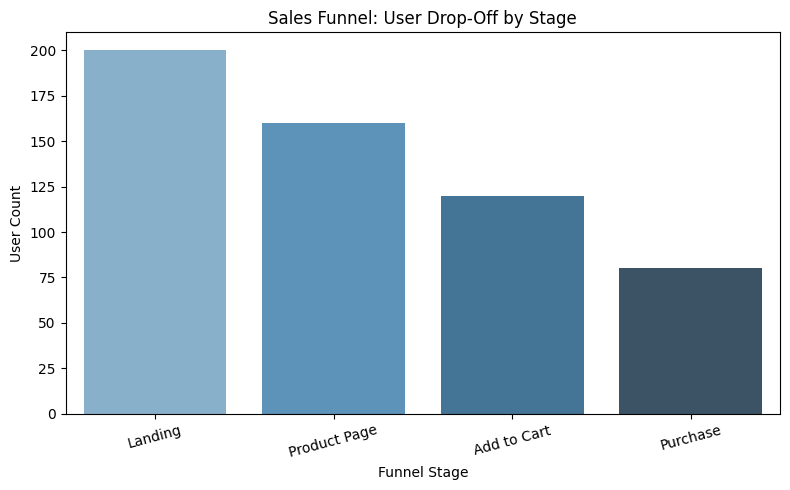

In [81]:
funnel_counts = [200, 160, 120, 80]
stages        = ["Landing", "Product Page", "Add to Cart", "Purchase"]

plt.figure(figsize=(8,5))
sns.barplot(x=stages, y=funnel_counts, palette="Blues_d")
plt.title("Sales Funnel: User Drop-Off by Stage")
plt.xlabel("Funnel Stage")
plt.ylabel("User Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("Sales_Funnel_User_Drop_Off_by_Stage.png", dpi=300, bbox_inches='tight')
plt.show()

## Step 6: Visualize Conversion Rates

Now a **line plot** of % conversion at each step, 
so we can spot steep drop-offs easily.


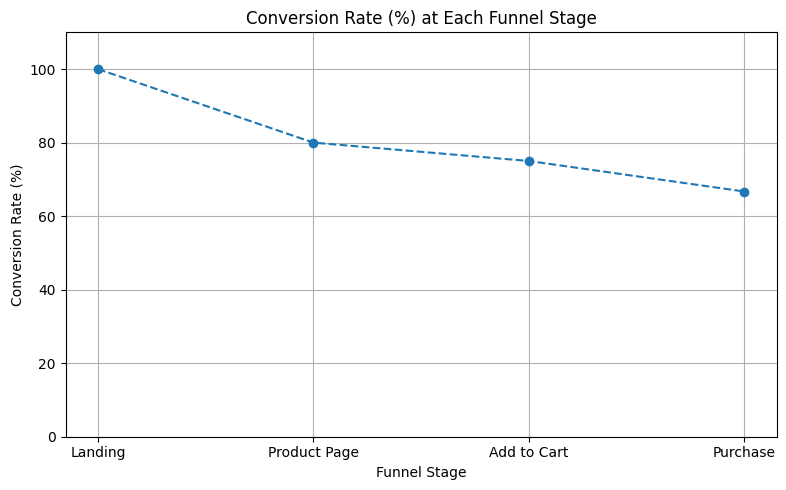

In [79]:
conversion_rates = [100, 80, 75, 66.7]  
plt.figure(figsize=(8,5))
plt.plot(stages, conversion_rates, marker="o", linestyle="--")
plt.title("Conversion Rate (%) at Each Funnel Stage")
plt.ylim(0,110)
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Funnel Stage")
plt.grid(True)
plt.tight_layout()
plt.savefig("Conversion Rate (%) at Each Funnel Stage.png", dpi=300, bbox_inches='tight')
plt.show()

## Step 7: Funnel Performance by Campaign & Source

We join all four tables on `user_id` and group by `campaign_id` & `source` to see:
- How many users entered at landing  
- How many progressed to each next stage  
- Calculate `% purchase conversion` per campaign & source  


In [84]:
query_by_campaign = """
SELECT
  l.campaign_id,
  l.source,
  COUNT(DISTINCT l.user_id)   AS landing_users,
  COUNT(DISTINCT p.user_id)   AS product_users,
  COUNT(DISTINCT c.user_id)   AS cart_users,
  COUNT(DISTINCT pr.user_id)  AS purchase_users
FROM landing_page_visits AS l
LEFT JOIN product_page_views AS p ON l.user_id = p.user_id
LEFT JOIN add_to_cart         AS c ON l.user_id = c.user_id
LEFT JOIN purchases           AS pr ON l.user_id = pr.user_id
GROUP BY l.campaign_id, l.source
ORDER BY landing_users DESC;
"""

df_campaign = pd.read_sql(query_by_campaign, conn)
df_campaign["purchase_rate_pct"] = (df_campaign["purchase_users"] * 100.0 / df_campaign["landing_users"]).round(2)
df_campaign.head()

,campaign_id,source,landing_users,product_users,cart_users,purchase_users,purchase_rate_pct
0,cmp_A,paid,38,29,21,14,36.84
1,cmp_A,referral,35,28,19,15,42.86
2,cmp_B,referral,33,29,21,18,54.55
3,cmp_B,paid,32,26,21,10,31.25
4,cmp_A,organic,31,23,19,10,32.26


## Step 8: Plot Conversion by Campaign & Source

We’ll build an **interactive Plotly bar chart** to compare purchase rates:

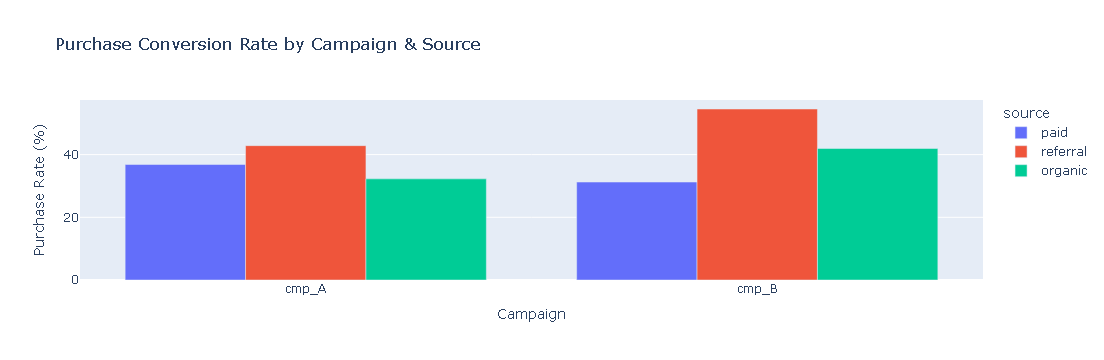

In [86]:
fig = px.bar(
    df_campaign,
    x="campaign_id",
    y="purchase_rate_pct",
    color="source",
    barmode="group",
    title="Purchase Conversion Rate by Campaign & Source"
)
fig.update_layout(xaxis_title="Campaign", yaxis_title="Purchase Rate (%)")
fig.write_image("Purchase Conversion Rate by Campaign & Source.png", width=800, height=500)
fig.show()

## Step 9: Users Dropped After Landing Page

Let's identify how many users **only landed** but never viewed a product.  
This is a key indicator of **landing page effectiveness**.


In [87]:
query4 = """
SELECT COUNT(DISTINCT l.user_id) AS dropped_after_landing
FROM landing_page_visits l
LEFT JOIN product_page_views p ON l.user_id = p.user_id
WHERE p.user_id IS NULL;
"""
pd.read_sql(query4, conn)

,dropped_after_landing
0,40


## Step 10: Users Who Added to Cart but Didn't Purchase

Cart abandoners are high-intent users.  
We should analyze them further for retargeting opportunities.

In [88]:
query5 = """
SELECT COUNT(DISTINCT c.user_id) AS cart_abandoners
FROM add_to_cart c
LEFT JOIN purchases p ON c.user_id = p.user_id
WHERE p.user_id IS NULL;
"""
pd.read_sql(query5, conn)

,cart_abandoners
0,40


WARNING	Thread(Thread-9 (run)) Task(Task-118) choreographer.browser_async:browser_async.py:_close()- Resorting to unclean kill browser.


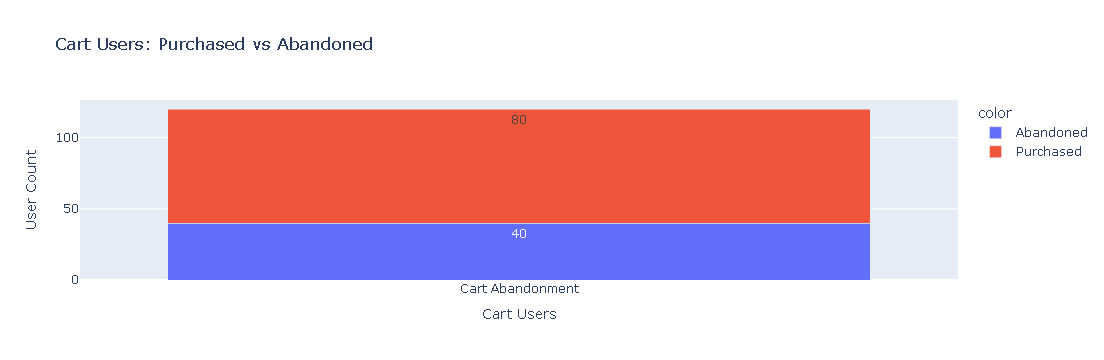

In [90]:
# Prepare funnel abandonment data
cart = pd.read_sql("""
    SELECT COUNT(DISTINCT user_id) AS cart_users FROM add_to_cart
""", conn).iloc[0, 0]

no_purchase = pd.read_sql("""
    SELECT COUNT(DISTINCT c.user_id) AS cart_abandoners
    FROM add_to_cart c
    LEFT JOIN purchases p ON c.user_id = p.user_id
    WHERE p.user_id IS NULL;
""", conn).iloc[0, 0]

purchase = cart - no_purchase

fig = px.bar(
    x=["Cart Abandonment", "Cart Abandonment"],
    y=[no_purchase, purchase],
    color=["Abandoned", "Purchased"],
    text=[no_purchase, purchase],
    title="Cart Users: Purchased vs Abandoned",
    labels={"x": "Cart Users", "y": "User Count"},
)
fig.update_layout(barmode='stack')
fig.write_image("Cart+Users_Purchased_vs_Abandoned.png", width=800, height=500)
fig.show()

## Step 11: Conversion Funnel for Instagram Traffic

Now let's isolate traffic from **Paid Campaign** and analyze their full funnel journey.

In [91]:
query6 = """
SELECT
  COUNT(DISTINCT l.user_id) AS landing,
  COUNT(DISTINCT pv.user_id) AS product,
  COUNT(DISTINCT a.user_id) AS cart,
  COUNT(DISTINCT p.user_id) AS purchase
FROM landing_page_visits l
LEFT JOIN product_page_views pv ON l.user_id = pv.user_id
LEFT JOIN add_to_cart a ON l.user_id = a.user_id
LEFT JOIN purchases p ON l.user_id = p.user_id
WHERE l.source = 'paid';
"""
pd.read_sql(query6, conn)

,landing,product,cart,purchase
0,70,55,42,24


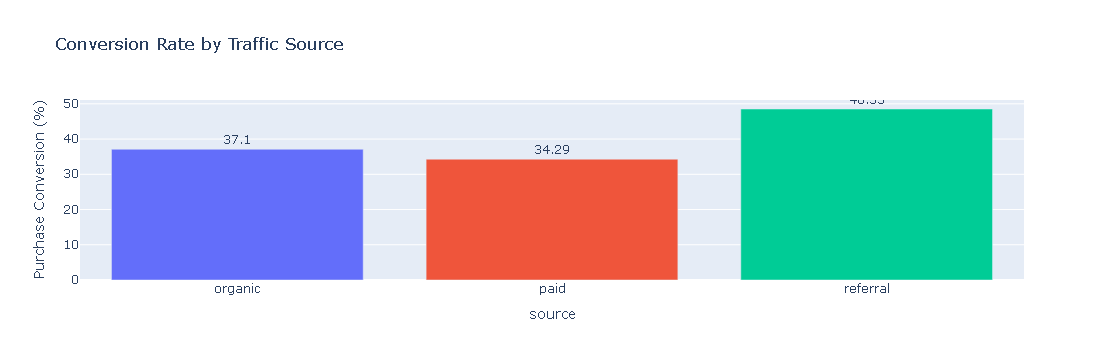

In [92]:
# Funnel by source
query7 = """
SELECT
    l.source,
    COUNT(DISTINCT l.user_id) AS landing_users,
    COUNT(DISTINCT p.user_id) AS purchase_users
FROM landing_page_visits l
LEFT JOIN purchases p ON l.user_id = p.user_id
GROUP BY l.source
"""
df_source = pd.read_sql(query7, conn)
df_source["conversion_rate"] = (df_source["purchase_users"] * 100 / df_source["landing_users"]).round(2)

fig = px.bar(
    df_source,
    x="source",
    y="conversion_rate",
    text="conversion_rate",
    color="source",
    title="Conversion Rate by Traffic Source",
    labels={"conversion_rate": "Purchase Conversion (%)"},
)
fig.update_traces(textposition="outside")
fig.update_layout(showlegend=False)
fig.write_image("Conversion Rate by Traffic Source.png", width=800, height=500)
fig.show()

## Step 12: Daily Purchase Trend

If timestamp exists, we can identify **which days** had more purchases.  
This could help optimize **ad timing** or discount events.

In [97]:
query8 = """
SELECT DATE(timestamp) AS purchase_day, COUNT(*) AS purchases
FROM purchases
GROUP BY purchase_day
ORDER BY purchase_day;
"""
df_time = pd.read_sql(query8, conn)
df_time

,purchase_day,purchases
0,2023-01-01,2
1,2023-01-02,2
2,2023-01-03,4
3,2023-01-04,3
4,2023-01-05,3
5,2023-01-07,3
6,2023-01-08,4
7,2023-01-09,6
8,2023-01-10,2
9,2023-01-11,2


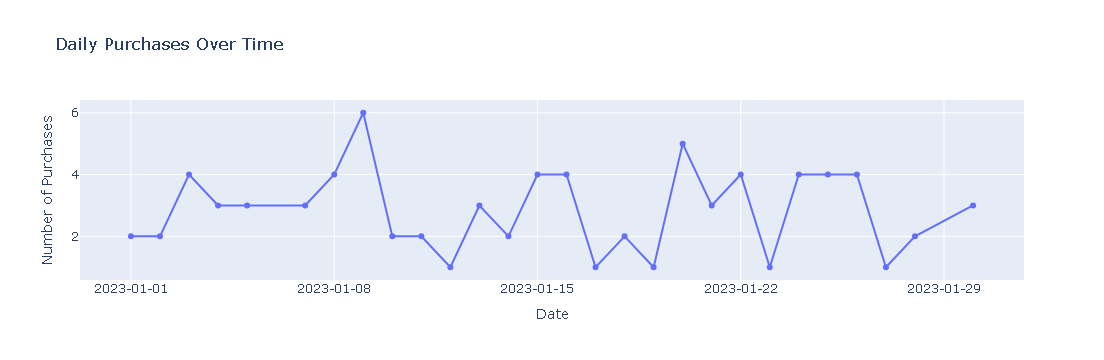

In [102]:
# Purchases per day
fig = px.line(
    df_time,
    x="day",
    y="purchases",
    title="Daily Purchases Over Time",
    labels={"day": "Date", "purchases": "Number of Purchases"},
    markers=True
)
fig.update_layout(xaxis_tickformat="%Y-%m-%d")
fig.write_image("Daily Purchases Over Time.png", width=800, height=500)
fig.show()

## Step 13: Purchase Rate by Campaign

This query compares campaigns based on their **purchase conversion rate**.

In [103]:
query9 = """
SELECT
  l.campaign_id,
  COUNT(DISTINCT l.user_id) AS total_users,
  COUNT(DISTINCT p.user_id) AS buyers,
  ROUND(COUNT(DISTINCT p.user_id)*100.0 / COUNT(DISTINCT l.user_id), 2) AS purchase_rate
FROM landing_page_visits l
LEFT JOIN purchases p ON l.user_id = p.user_id
GROUP BY l.campaign_id
ORDER BY purchase_rate DESC;
"""
df_campaign = pd.read_sql(query9, conn)
df_campaign

,campaign_id,total_users,buyers,purchase_rate
0,cmp_B,96,41,42.71
1,cmp_A,104,39,37.50


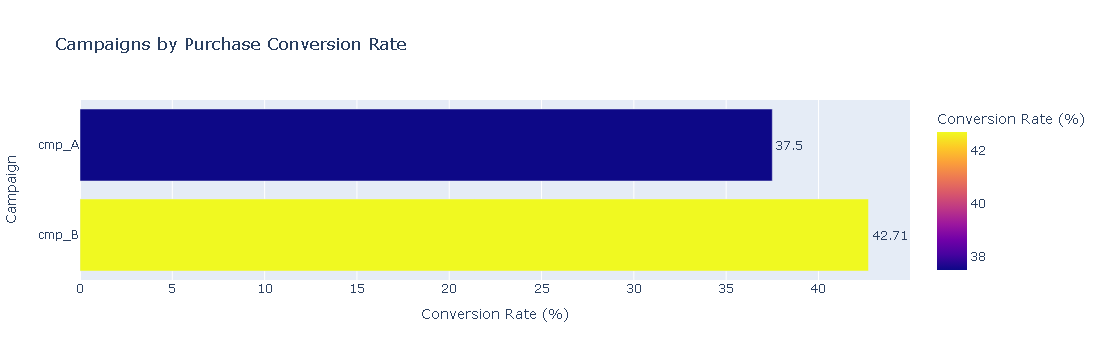

In [104]:
# Campaign-wise purchase rate
fig = px.bar(
    df_campaign,
    x="purchase_rate",
    y="campaign_id",
    orientation="h",
    text="purchase_rate",
    color="purchase_rate",
    title="Campaigns by Purchase Conversion Rate",
    labels={"purchase_rate": "Conversion Rate (%)", "campaign_id": "Campaign"},
)
fig.update_traces(textposition="outside")
fig.write_image("Campaigns by Purchase Conversion Rate.png", width=800, height=500)
fig.show()

## Step 14: Detect Duplicate User Sessions

Are any users appearing multiple times in multiple funnel stages?  
This can help check for **session anomalies or bot activity**.

In [105]:
query10 = """
SELECT user_id, COUNT(*) AS times_seen
FROM (
  SELECT user_id FROM landing_page_visits
  UNION ALL
  SELECT user_id FROM product_page_views
  UNION ALL
  SELECT user_id FROM add_to_cart
  UNION ALL
  SELECT user_id FROM purchases
)
GROUP BY user_id
HAVING times_seen > 1
ORDER BY times_seen DESC
LIMIT 10;
"""
df_dupes = pd.read_sql(query10, conn)
df_dupes

,user_id,times_seen
0,user_99,4
1,user_95,4
2,user_94,4
3,user_92,4
4,user_90,4
5,user_9,4
6,user_88,4
7,user_86,4
8,user_84,4
9,user_82,4


## Step 15: Users Who Completed Full Funnel

This query finds users who **did everything**:  
Landing → Product → Cart → Purchase.

In [106]:
query11 = """
SELECT COUNT(*) AS full_funnel_users
FROM (
  SELECT l.user_id
  FROM landing_page_visits l
  INNER JOIN product_page_views p ON l.user_id = p.user_id
  INNER JOIN add_to_cart a ON l.user_id = a.user_id
  INNER JOIN purchases pr ON l.user_id = pr.user_id
);
"""
pd.read_sql(query11, conn)

,full_funnel_users
0,80


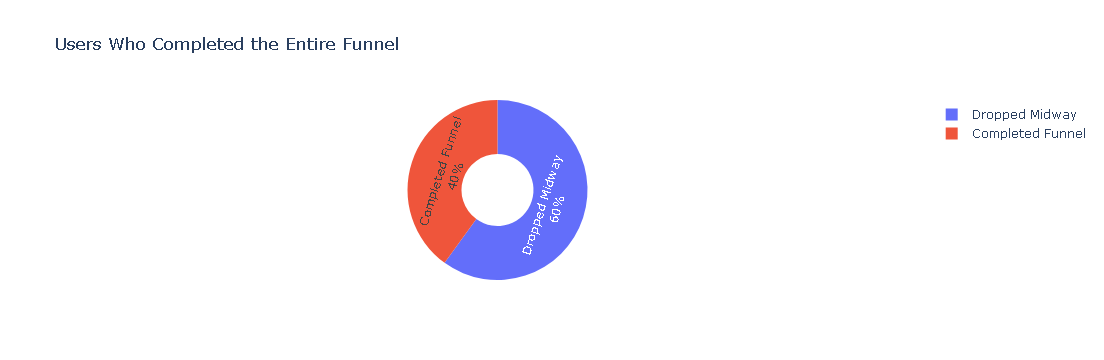

In [107]:
# Total funnel starters
total_landing = pd.read_sql("SELECT COUNT(DISTINCT user_id) FROM landing_page_visits", conn).iloc[0, 0]

# Full funnel finishers
full_funnel = pd.read_sql(query11, conn).iloc[0, 0]

# Prepare pie data
fig = px.pie(
    names=["Completed Funnel", "Dropped Midway"],
    values=[full_funnel, total_landing - full_funnel],
    title="Users Who Completed the Entire Funnel",
    hole=0.4
)
fig.update_traces(textinfo='percent+label')
fig.write_image("Users Who Completed the Entire Funnel.png", width=800, height=500)
fig.show()

In [108]:
conn.close()